In [12]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numba as nb
from sklearn.metrics import r2_score

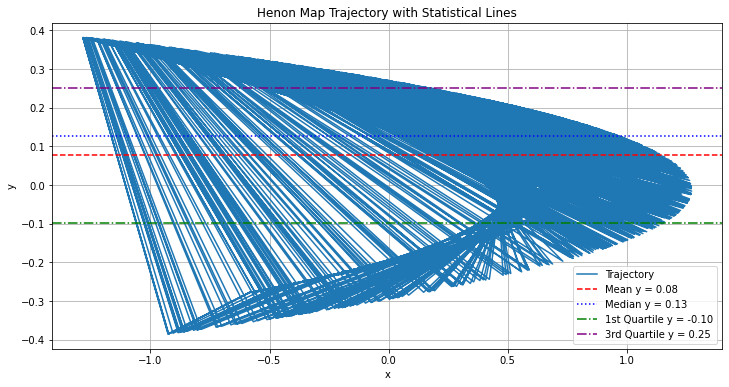

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def find_intercepts_2d(x, y, line_y):
    """
    Identify where a 2D trajectory crosses a horizontal line y = line_y.

    Parameters:
    - x (array): x-coordinates of the trajectory.
    - y (array): y-coordinates of the trajectory.
    - line_y (float): The y-coordinate of the line to check for intercepts.

    Returns:
    - list: x-coordinates of points where the trajectory crosses the line.
    """
    intercepts = []
    for i in range(1, len(y)):
        if (y[i-1] < line_y and y[i] > line_y) or (y[i-1] > line_y and y[i] < line_y):
            # Linear interpolation to find the x-coordinate of the intercept
            slope = (x[i] - x[i-1]) / (y[i] - y[i-1])
            intercept_x = x[i-1] + (line_y - y[i-1]) / slope
            intercepts.append(intercept_x)
    return intercepts

def plot_trajectory_and_significant_lines(x, y, title='Trajectory with Significant Lines'):
    """
    Plot the trajectory of a 2D system with lines corresponding to significant statistical thresholds.
    
    Parameters:
    - x (list): x-coordinates of the trajectory.
    - y (list): y-coordinates of the trajectory.
    - title (str): Title of the plot.
    """
    mean_y = np.mean(y)
    std_y = np.std(y)
    median_y = np.median(y)
    quartile1 = np.percentile(y, 25)
    quartile3 = np.percentile(y, 75)

    plt.figure(figsize=(12, 6))
    plt.plot(x, y, label='Trajectory')
    plt.axhline(y=mean_y, color='red', linestyle='--', label=f'Mean y = {mean_y:.2f}')
    plt.axhline(y=median_y, color='blue', linestyle=':', label=f'Median y = {median_y:.2f}')
    plt.axhline(y=quartile1, color='green', linestyle='-.', label=f'1st Quartile y = {quartile1:.2f}')
    plt.axhline(y=quartile3, color='purple', linestyle='-.', label=f'3rd Quartile y = {quartile3:.2f}')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate data for the Henon map (as previously defined)
a, b = 1.4, 0.3
def henon_map(x, y):
    return y + 1 - a * x**2, b * x

x, y = 0, 0
xs, ys = [], []
for _ in range(1000):
    x, y = henon_map(x, y)
    xs.append(x)
    ys.append(y)

plot_trajectory_and_significant_lines(xs, ys, 'Henon Map Trajectory with Statistical Lines')


In [14]:
def lyapunov_exponent(x, y, num_iters, f_map):
    """ Calculate the first Lyapunov exponent for a 2D map """
    delta = 1e-5
    sum_log = 0.0
    for _ in range(num_iters):
        x_next, y_next = f_map(x, y)
        x_delta, y_delta = f_map(x + delta, y)
        delta_x = ((x_delta - x_next)**2 + (y_delta - y_next)**2)**0.5
        sum_log += np.log(delta_x / delta)
        x, y = x_next, y_next
    return sum_log / num_iters

# Calculate the Lyapunov exponent for the Henon map
L_exp = lyapunov_exponent(0, 0, 1000, henon_map)
print("Estimated Lyapunov Exponent:", L_exp)

Estimated Lyapunov Exponent: 0.49737152150168246


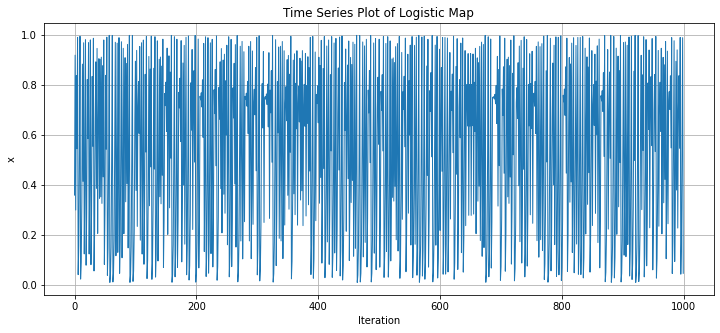

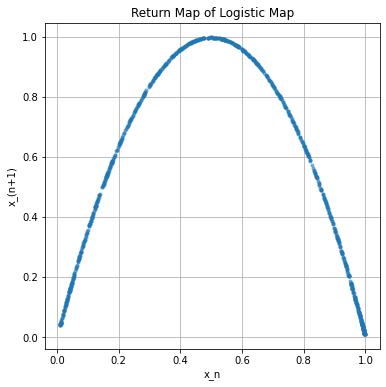

In [15]:

def logistic_map(r, x):
    return r * x * (1 - x)

# Parameters
r = 3.99  # Parameter close to 4 shows chaotic behavior
iterations = 1000
x = 0.1  # Initial condition

# Generate data
data = []
for _ in range(iterations):
    x = logistic_map(r, x)
    data.append(x)

# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(data, lw=1)
plt.title('Time Series Plot of Logistic Map')
plt.xlabel('Iteration')
plt.ylabel('x')
plt.grid(True)
plt.show()

# Generate Return Map
plt.figure(figsize=(6, 6))
plt.plot(data[:-1], data[1:], '.', alpha=0.5)
plt.title('Return Map of Logistic Map')
plt.xlabel('x_n')
plt.ylabel('x_(n+1)')
plt.grid(True)
plt.show()
